In [1]:
## Import the libraries
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
from selenium import webdriver
from selenium.common.exceptions import WebDriverException
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from time import sleep
import pickle
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from kneed import KneeLocator

In [2]:
## Function to web scrape from the webpage
def get_data(page_source,DATA,category,country,page_num):
    content = BeautifulSoup(page_source,'html5lib')
    soups = content.findAll('div',{'class':'thumb-block'})
    for so in soups:
        if 'thumb-ad' not in so.get('class'):
            this_data = {}
            this_data['TITLE'] = so.find('p',{'class':'title'}).find('a').get('title')
            meta_data = so.find('p',{'class':'metadata'})
            quality = meta_data.find('span',{'class':'video-hd-mark'})
            if quality:
                this_data['QUALITY'] = quality.text
            else:
                quality = meta_data.find('span',{'class':'video-sd-mark'})
                if quality:
                    this_data['QUALITY'] = quality.text
                else:
                    this_data['QUALITY'] = 'NA'
            this_data['UPLOADER'] = meta_data.find('span',{'class':'name'}).text
            this_data['VIEWS'] = re.search(r'\d+\.?\d*[kM]?',meta_data.find('span',{'class':'sprfluous'}).parent.text).group()
            this_data['CATEGORY'] = category
            this_data['COUNTRY'] = country
            this_data['PAGE_NUMBER'] = page_num
            DATA.append(this_data)
    return DATA

In [3]:
## Base URL to which endpoints are added to 
BASE_URL = 'https://www.xvideos.com/change-country/'

## Dictionary containing Countries name with their end points
COUNTRIES_DICT = {'Afghanistan': 'af', 'Chad': 'td', 'Greece': 'gr', 'Libya': 'ly', 'Pakistan': 'pk', 'Sudan': 'sd', \
                  'Albania': 'al', 'Chile': 'cl', 'Greenland': 'gl', 'Liechtenstein': 'li', 'Palau': 'pw',\
                  'Suriname': 'sr', 'Algeria': 'dz', 'China': 'cn', 'Grenada': 'gd', 'Lithuania': 'lt',\
                  'Palestinian Territory': 'ps', 'Swaziland': 'sz', 'American Samoa': 'as', 'Christmas Island': 'cx',\
                  'Guadeloupe': 'gp', 'Luxembourg': 'lu', 'Panama': 'pa', 'Sweden': 'se', 'Andorra': 'ad',\
                  'Cocos (Keeling) Islands': 'cc', 'Guam': 'gu', 'Macao': 'mo', 'Papua New Guinea': 'pg',\
                  'Switzerland': 'ch', 'Angola': 'ao', 'Colombia': 'co', 'Guatemala': 'gt', 'Macedonia': 'mk',\
                  'Paraguay': 'py', 'Syrian Arab Republic': 'sy', 'Anguilla': 'ai', 'Comoros': 'km', 'Guernsey': 'gg',\
                  'Madagascar': 'mg', 'Peru': 'pe', 'Taiwan': 'tw', 'Antarctica': 'aq', 'Congo': 'cg', 'Guinea': 'gn',\
                  'Malawi': 'mw', 'Philippines': 'ph', 'Tajikistan': 'tj', 'Antigua and Barbuda': 'ag',\
                  'Congo, The Democratic Republic of the': 'cd', 'Guinea-Bissau': 'gw', 'Malaysia': 'my', 'Poland': 'pl',\
                  'Tanzania, United Republic of': 'tz', 'Argentina': 'ar', 'Cook Islands': 'ck', 'Guyana': 'gy',\
                  'Maldives': 'mv', 'Portugal': 'pt', 'Thailand': 'th', 'Åland Islands': 'ax', 'Costa Rica': 'cr',\
                  'Haiti': 'ht', 'Mali': 'ml', 'Puerto Rico': 'pr', 'Timor-Leste': 'tl', 'Armenia': 'am',\
                  "Cote d'Ivoire": 'ci', 'Holy See (Vatican City State)': 'va', 'Malta': 'mt', 'Qatar': 'qa',\
                  'Togo': 'tg', 'Aruba': 'aw', 'Croatia': 'hr', 'Honduras': 'hn', 'Marshall Islands': 'mh',\
                  'Reunion': 're', 'Tokelau': 'tk', 'Australia': 'au', 'Cuba': 'cu', 'Hong Kong': 'hk',\
                  'Martinique': 'mq', 'Romania': 'ro', 'Tonga': 'to', 'Austria': 'at', 'Curaçao': 'cw', 'Hungary': 'hu',\
                  'Mauritania': 'mr', 'Russia': 'ru', 'Trinidad and Tobago': 'tt', 'Azerbaijan': 'az', 'Cyprus': 'cy',\
                  'Iceland': 'is', 'Mauritius': 'mu', 'Rwanda': 'rw', 'Tunisia': 'tn', 'Bahamas': 'bs',\
                  'Czech Republic': 'cz', 'India': 'in', 'Mayotte': 'yt', 'Saint-Barthélemy': 'bl', 'Turkey': 'tr',\
                  'Bahrain': 'bh', 'Denmark': 'dk', 'Indonesia': 'id', 'Mexico': 'mx', 'Saint Helena': 'sh',\
                  'Turkmenistan': 'tm', 'Bangladesh': 'bd', 'Djibouti': 'dj', 'Iran, Islamic Republic of': 'ir',\
                  'Micronesia, Federated States of': 'fm', 'Saint Kitts and Nevis': 'kn', 'Turks and Caicos Islands': 'tc',\
                  'Barbados': 'bb', 'Dominica': 'dm', 'Iraq': 'iq', 'Moldova, Republic of': 'md', 'Saint Lucia': 'lc',\
                  'Tuvalu': 'tv', 'Belarus': 'by', 'Dominican Republic': 'do', 'Ireland': 'ie', 'Monaco': 'mc',\
                  'Saint Martin': 'mf', 'Uganda': 'ug', 'Belgium': 'be', 'Ecuador': 'ec', 'Isle of Man': 'im',\
                  'Mongolia': 'mn', 'Saint Pierre and Miquelon': 'pm', 'Ukraine': 'ua', 'Belize': 'bz', 'Egypt': 'eg',\
                  'Israel': 'il', 'Montenegro': 'me', 'Saint Vincent and the Grenadines': 'vc',\
                  'United Arab Emirates': 'ae', 'Benin': 'bj', 'El Salvador': 'sv', 'Italy': 'it', 'Montserrat': 'ms',\
                  'Samoa': 'ws', 'United Kingdom': 'gb', 'Bermuda': 'bm', 'Equatorial Guinea': 'gq', 'Jamaica': 'jm',\
                  'Morocco': 'ma', 'San Marino': 'sm', 'Uruguay': 'uy', 'Bhutan': 'bt', 'Eritrea': 'er', 'Japan': 'jp',\
                  'Mozambique': 'mz', 'Sao Tome and Principe': 'st', 'USA': 'us', 'Bolivia': 'bo', 'Estonia': 'ee',\
                  'Jersey': 'je', 'Myanmar': 'mm', 'Saudi Arabia': 'sa', 'Uzbekistan': 'uz', 'Bosnia and Herzegovina': 'ba',\
                  'Ethiopia': 'et', 'Jordan': 'jo', 'Namibia': 'na', 'Senegal': 'sn', 'Vanuatu': 'vu', 'Botswana': 'bw',\
                  'Falkland Islands (Malvinas)': 'fk', 'Kazakhstan': 'kz', 'Nauru': 'nr', 'Serbia': 'rs', 'Venezuela': 've',\
                  'Brazil': 'br', 'Faroe Islands': 'fo', 'Kenya': 'ke', 'Nepal': 'np', 'Seychelles': 'sc', 'Vietnam': 'vn',\
                  'Brunei Darussalam': 'bn', 'Fiji': 'fj', 'Kiribati': 'ki', 'Netherlands': 'nl', 'Sierra Leone': 'sl',\
                  'Virgin Islands, British': 'vg', 'Bulgaria': 'bg', 'Finland': 'fi', 'Korea': 'kr',\
                  'Netherlands Antilles': 'an', 'Singapore': 'sg', 'Virgin Islands, U.S.': 'vi', 'Burkina Faso': 'bf',\
                  'France': 'fr', "Korea, Democratic People's Republic of": 'kp', 'New Caledonia': 'nc',\
                  'Sint Maarten': 'sx', 'Wallis and Futuna': 'wf', 'Burundi': 'bi', 'French Guiana': 'gf', 'Kosovo': 'xk',\
                  'New Zealand': 'nz', 'Slovakia': 'sk', 'Western Sahara': 'eh', 'Cambodia': 'kh', 'French Polynesia': 'pf',\
                  'Kuwait': 'kw', 'Nicaragua': 'ni', 'Slovenia': 'si', 'Yemen': 'ye', 'Cameroon': 'cm', 'Gabon': 'ga',\
                  'Kyrgyzstan': 'kg', 'Niger': 'ne', 'Solomon Islands': 'sb', 'Zambia': 'zm', 'Canada': 'ca', 'Gambia': 'gm',\
                  "Lao People's Democratic Republic": 'la', 'Nigeria': 'ng', 'Somalia': 'so', 'Zimbabwe': 'zw',\
                  'Cape Verde': 'cv', 'Georgia': 'ge', 'Latvia': 'lv', 'Niue': 'nu', 'South Africa': 'za',\
                  'Caribbean Netherlands': 'bq', 'Germany': 'de', 'Lebanon': 'lb', 'Northern Mariana Islands': 'mp',\
                  'South Sudan': 'ss', 'Cayman Islands': 'ky', 'Ghana': 'gh', 'Lesotho': 'ls', 'Norway': 'no', 'Spain': 'es',\
                  'Central African Republic': 'cf', 'Gibraltar': 'gi', 'Liberia': 'lr', 'Oman': 'om', 'Sri Lanka': 'lk'}

In [4]:
## Number of countries 
len(COUNTRIES_DICT)

242

In [5]:
DATA_LIST = [] ## list to which all data is appended to 
SMALL_DICT = {} # Dictionary to which countries are added if there is some error
for index,country_name_id in enumerate(COUNTRIES_DICT.items()): # Looping in the all the countries 
    try: # try and except block to catch error 
        country_name,country_id = country_name_id
        print(index,country_name)
        ser = Service('./chromedriver.exe')
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument("--incognito")
        driver = webdriver.Chrome(service=ser,options=chrome_options)
        driver.get(BASE_URL + COUNTRIES_DICT.get(country_name))
        element = driver.find_element(By.XPATH,'//*[@id="disclaimer-content"]/button')
        driver.execute_script("arguments[0].click();", element)
        
        driver.implicitly_wait(15)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'HOME',country_name,1)

        element = driver.find_element(By.XPATH,'//*[@id="content"]/div[2]/ul/li[1]/a') # Page_2
        driver.execute_script("arguments[0].click();", element)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'HOME',country_name,2)
        driver.implicitly_wait(5)

        element = driver.find_element(By.XPATH,'//*[@id="main"]/div[3]/ul/li[2]/a') # Page_3
        driver.execute_script("arguments[0].click();", element)
        driver.implicitly_wait(5)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'HOME',country_name,3)
        
        element = driver.find_element(By.XPATH,'//*[@id="main"]/div[3]/ul/li[3]/a') # Page_4
        driver.execute_script("arguments[0].click();", element)
        driver.implicitly_wait(5)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'HOME',country_name,4)
        
        
        element = driver.find_element(By.XPATH,'//*[@id="main"]/div[3]/ul/li[4]/a') # Page_5
        driver.execute_script("arguments[0].click();", element)
        driver.implicitly_wait(5)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'HOME',country_name,5)
        
        
        element = driver.find_element(By.XPATH,'//*[@id="header-menu-toggle"]') # Toggle for best
        driver.execute_script("arguments[0].click();", element)
        element = driver.find_element(By.XPATH,'//*[@id="nav"]/nav/div[1]/ul/li[7]/a') # Best Page December
        driver.execute_script("arguments[0].click();", element)
        driver.implicitly_wait(5)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'BEST',country_name,1)

        element = driver.find_element(By.XPATH,'//*[@id="date-links-pagination"]/ul/li[2]/a') # Best Page November
        driver.execute_script("arguments[0].click();", element)
        driver.implicitly_wait(5)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'BEST',country_name,2)

        element = driver.find_element(By.XPATH,'//*[@id="date-links-pagination"]/ul/li[3]/a') # Best Page October
        driver.execute_script("arguments[0].click();", element)
        driver.implicitly_wait(5)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'BEST',country_name,3)
        
        element = driver.find_element(By.XPATH,'//*[@id="date-links-pagination"]/ul/li[4]/a') # Best Page September
        driver.execute_script("arguments[0].click();", element)
        driver.implicitly_wait(5)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'BEST',country_name,3)
        
        element = driver.find_element(By.XPATH,'//*[@id="date-links-pagination"]/ul/li[5]/a') # Best Page August
        driver.execute_script("arguments[0].click();", element)
        driver.implicitly_wait(5)
        DATA_LIST = get_data(driver.page_source,DATA_LIST,'BEST',country_name,3)
        
        driver.quit()
        df = pd.DataFrame.from_records(DATA_LIST)
        df.to_csv('C:/Users/raghu/Desktop/PORNOGRAPHY_DATA_1.csv',index=False)
    except WebDriverException:
        print("page down")
        SMALL_DICT[country_name] = country_id
        driver.quit()
        sleep(60)

0 Afghanistan
1 Chad
2 Greece
3 Libya
4 Pakistan
5 Sudan
6 Albania
7 Chile
8 Greenland
9 Liechtenstein
10 Palau
11 Suriname
12 Algeria
13 China
14 Grenada
15 Lithuania
16 Palestinian Territory
17 Swaziland
18 American Samoa
19 Christmas Island
20 Guadeloupe
21 Luxembourg
22 Panama
23 Sweden
24 Andorra
25 Cocos (Keeling) Islands
26 Guam
27 Macao
28 Papua New Guinea
29 Switzerland
30 Angola
31 Colombia
32 Guatemala
33 Macedonia
34 Paraguay
35 Syrian Arab Republic
36 Anguilla
37 Comoros
38 Guernsey
39 Madagascar
40 Peru
41 Taiwan
42 Antarctica
43 Congo
44 Guinea
45 Malawi
46 Philippines
47 Tajikistan
48 Antigua and Barbuda
49 Congo, The Democratic Republic of the
50 Guinea-Bissau
51 Malaysia
52 Poland
53 Tanzania, United Republic of
54 Argentina
55 Cook Islands
56 Guyana
57 Maldives
58 Portugal
59 Thailand
60 Åland Islands
61 Costa Rica
62 Haiti
63 Mali
64 Puerto Rico
65 Timor-Leste
66 Armenia
67 Cote d'Ivoire
68 Holy See (Vatican City State)
69 Malta
70 Qatar
71 Togo
72 Aruba
73 Croatia


In [5]:
df = pd.read_csv('C:/Users/raghu/Desktop/PORNOGRAPHY_DATA.csv')  ## Reading the pornography csv file 

In [6]:
df.head() ## Viewing head or tail to check the data

TITLE QUALITY  \
0  Hard fucked in oyo hotel room in clear Hindi a...    720p   
1  ACCIDENTAL CREAMPIE on THICK ANAL LOVER Sofia ...   1440p   
2                                         Greta gyno    720p   
3  Brave Redhead Getting Fucked on All Fours and ...   1080p   
4                    Desi Telugu couple Romantic sex   1080p   

           UPLOADER   VIEWS CATEGORY      COUNTRY  PAGE_NUMBER  
0     Coolfriend986  349.2k     HOME  Afghanistan            1  
1         Porno Dan    1.2M     HOME  Afghanistan            1  
2  Xvideos100000000  120.1k     HOME  Afghanistan            1  
3        Coupleluna  220.8k     HOME  Afghanistan            1  
4   Desi Hot Couple  174.8k     HOME  Afghanistan            1

In [7]:
## Function get_views to extract number of views from views in the string format 
def get_views(string):
    number = float(re.search(r'\d+\.?\d*',string).group())
    if ('K' in string) or ('k' in string):
        return 1000*number
    elif ('m' in string) or ('M' in string):
        return 1000000*number
    else:
        return number
df['VIEWS'] = df['VIEWS'].map(lambda x: get_views(x))/1000

In [8]:
## Top 5 duplicated video titles 
df[['TITLE']].reset_index().groupby('TITLE').count().nlargest(5,columns='index')

index
TITLE                                                    
Petite pussy pumped with cum                          186
(Kyle Mason) Is More Than Happy When He Realize...    171
BBC Big Black Dick Can’t Fit In Teen Cumshot On...    171
Mom creeps up at night                                167
Busty Step Sister Lets Her Horny Step Brother P...    164

In [9]:
len(df) ## Total of 7-196 records

70196

In [10]:
df.drop_duplicates(subset='TITLE').isna().sum() ## Null or missing values for any videos if there 

TITLE            0
QUALITY        267
UPLOADER         0
VIEWS            0
CATEGORY         0
COUNTRY          0
PAGE_NUMBER      0
dtype: int64

Text(0, 0.5, 'Number of Video')

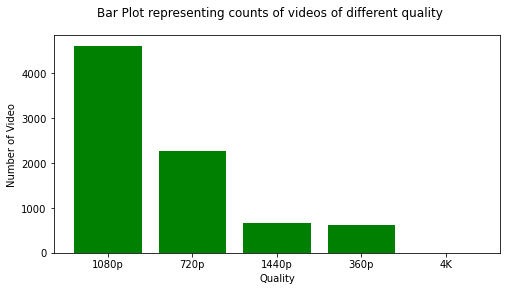

In [11]:
df.drop_duplicates(subset='TITLE')['QUALITY'].value_counts() # How many videos are there for respective qualities 

dict_plot = df.drop_duplicates(subset='TITLE')['QUALITY'].value_counts().to_dict()
fig = plt.figure(figsize=(8,4))
plt.bar(dict_plot.keys(), dict_plot.values(), color='g',)
fig.suptitle('Bar Plot representing counts of videos of different quality')
plt.xlabel('Quality')
plt.ylabel('Number of Video')

In [12]:
len(df['COUNTRY'].unique()) ## Number of countries

242

In [13]:
len(df.drop_duplicates(subset='TITLE')['TITLE'].unique()) ## Number of Unique videos

8447

In [14]:
len(df.drop_duplicates(subset='TITLE')['UPLOADER'].unique()) ## Number of unique uploaders

4157

Text(0, 0.5, 'Number of Videos by each uploader')

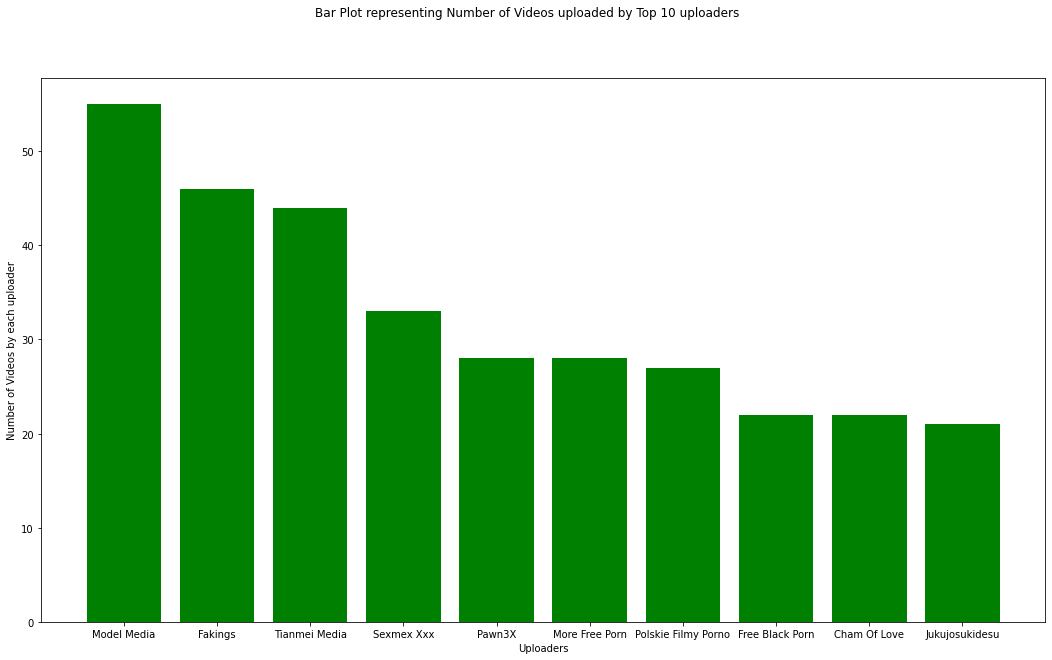

In [15]:
df.drop_duplicates(subset='TITLE')['UPLOADER'].value_counts().nlargest(10) # Top 10 uploaders with most video

dict_plot = df.drop_duplicates(subset='TITLE')['UPLOADER'].value_counts().nlargest(10).to_dict()
fig = plt.figure(figsize=(18,10))
plt.bar(dict_plot.keys(), dict_plot.values(), color='g',)
fig.suptitle('Bar Plot representing Number of Videos uploaded by Top 10 uploaders')
plt.xlabel('Uploaders')
plt.ylabel('Number of Videos by each uploader')

In [16]:
## Top 5 Video titles with most views (Method 1 - nlargest function )
df.loc[:,['TITLE','VIEWS','UPLOADER']].drop_duplicates(subset='TITLE').nlargest(5,columns=['VIEWS'])

TITLE    VIEWS  \
3803   BANGBROS - Curvy Latina Rose Monroe Fucked in ...  93700.0   
30215          Erotic Korean porn mature women young boy  89500.0   
11595  BANGBROS - Trump Sucks And Fucks A Big Black D...  83200.0   
3918                           Fucking my niece while s.  70100.0   
15070  BLACKED Japanese Journalist vs The BIGGEST BBC...  69900.0   

               UPLOADER  
3803   Bangbros Network  
30215           Javhot2  
11595     Brown Bunnies  
3918      Ivana Montana  
15070           Blacked

In [17]:
## Top 5 Video titles with most views (Method 2 - sorting all the videos wrt views in decending order )
df.loc[:,['TITLE','VIEWS','UPLOADER']].drop_duplicates(subset='TITLE').sort_values('VIEWS',ascending=False).head(5)

TITLE    VIEWS  \
3803   BANGBROS - Curvy Latina Rose Monroe Fucked in ...  93700.0   
30215          Erotic Korean porn mature women young boy  89500.0   
11595  BANGBROS - Trump Sucks And Fucks A Big Black D...  83200.0   
3918                           Fucking my niece while s.  70100.0   
15070  BLACKED Japanese Journalist vs The BIGGEST BBC...  69900.0   

               UPLOADER  
3803   Bangbros Network  
30215           Javhot2  
11595     Brown Bunnies  
3918      Ivana Montana  
15070           Blacked

In [18]:
## try it out and find the difference between this one and next one 
# df.drop_duplicates(subset='TITLE')[['UPLOADER','VIEWS']].groupby('UPLOADER').agg(['sum','count','mean']).nlargest(5,columns=('VIEWS',  'mean'))

In [19]:
## Uploaders with highiest average number of views per video uploaded condition that uploaded has uploaded more than 4 videos
popular_uploaders = list(df.drop_duplicates(subset='TITLE')['UPLOADER'].value_counts()\
                                             [df.drop_duplicates(subset='TITLE')['UPLOADER'].value_counts() >= 5].index)
popular_uploaders_df = df[df['UPLOADER'].isin(popular_uploaders)].drop_duplicates(subset='TITLE')[['UPLOADER','VIEWS']]\
                                    .groupby('UPLOADER').agg(['count','sum','mean']).nlargest(5,columns=('VIEWS','mean'))
popular_uploaders_df

VIEWS                        
                 count       sum          mean
UPLOADER                                      
Bangbros Network     7  186435.8  26633.685714
Topxxxcouple         5  106100.0  21220.000000
Brown Bunnies        5   95444.3  19088.860000
Your Priya          18  339400.0  18855.555556
Desi Gold            6   91600.0  15266.666667

Text(0, 0.5, 'Average/Mean Views ')

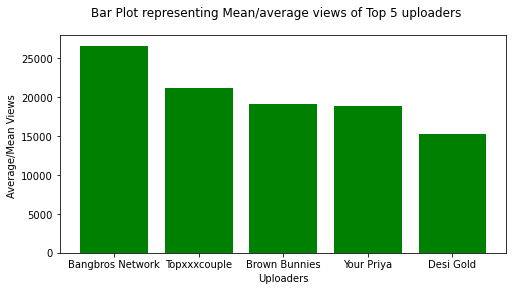

In [20]:
dict_plot = popular_uploaders_df[('VIEWS','mean')].to_dict()
fig = plt.figure(figsize=(8,4))
plt.bar(dict_plot.keys(), dict_plot.values(), color='g',)
fig.suptitle('Bar Plot representing Mean/average views of Top 5 uploaders')
plt.xlabel('Uploaders')
plt.ylabel('Average/Mean Views ')

In [21]:
## Regex to remove links from the links from the text
link_regex = re.compile(r'(?:ftp|https?|www|file)\.?:?[//|\\\\]?[\w\d:#@%/;$()~_?\+-=\\\&]+\.[\w\d:#@%/;$~_?\+-=\\\&]+')
df['TITLE'] = df['TITLE'].apply(lambda x: re.sub(link_regex,'',x))

df['TITLE'] = df['TITLE'].str.lower() ## lowercase all the text

## Read the contraction file
file = open('D:/MSC/NLP/NLP_ASS2/semeval-tweets/NEEDED/' + 'CONTRACTIONS.pkl', "rb")
CONTRACTION_MAP = pickle.load(file)
sleep(1)
del file
contraction = sorted(CONTRACTION_MAP, key=len, reverse=True)
c_re = re.compile('(%s)' % '|'.join(contraction))

## Function to expand the contrations
def expandContractions(text, c_re=c_re):
    def replace(match):
        return CONTRACTION_MAP[match.group(0)]
    return c_re.sub(replace, text.lower())
df['TITLE'] = df['TITLE'].apply(lambda x: expandContractions(x)) ## Applying function to expand ocntractions to text


df['TITLE'] = df['TITLE'].apply(lambda x: re.sub(r"['!\"“”‘’.?!…,:;]",'',x)) ## Remove punctutations


df['TITLE'] = df['TITLE'].apply(lambda x: re.sub(r'[^a-zA-Z\s0-9]','',x)) ## Keep only alphanumeric english characters

In [22]:
## Join all the Text/tiles for each country 
country_df = df[['TITLE','COUNTRY']].drop_duplicates().groupby('COUNTRY').agg({'TITLE':' '.join}).reset_index()
country_df['TITLE'] = country_df['TITLE'].apply(lambda x: re.sub(' +', ' ',x)) # remove extar white spaces
## Not needed 
replace_dict = {'Virgin Islands, British':'British Virgin Islands','Virgin Islands, U.S.':'United States Virgin Islands',
               'Vietnam':'Viet Nam','USA':'United States','Wallis and Futuna':'Wallis and Futuna Islands',
               'Moldova, Republic of':'Republic of Moldova','Congo, The Democratic Republic of the':'Democratic Republic of the Congo',
               'Macao':'Macau','Korea':'Korea, Republic of','Tanzania, United Republic of':'United Republic of Tanzania',
               'Åland Islands':'Εland Islands','Holy See (Vatican City State)':'Holy See (Vatican City)',
               'Iran, Islamic Republic of':'Iran (Islamic Republic of)','Macedonia':'The former Yugoslav Republic of Macedonia',
               'Libya':'Libyan Arab Jamahiriya','Saint-Barthélemy':'Saint Barthelemy','Palestinian Territory':'Palestine','Myanmar':'Burma'}

country_df['COUNTRY'] = country_df['COUNTRY'].replace(replace_dict)

In [23]:
ALL_CLUSTERS_DF = pd.DataFrame(columns=['COUNTRY'])
ALL_CLUSTERS_DF['COUNTRY'] = country_df['COUNTRY']

In [24]:
country_df['TOKENS'] = country_df['TITLE'].apply(lambda x: tokenize.word_tokenize(x)) ## Create tokens from the titles/text

In [25]:
country_df['TOKENS'].map(lambda x: len(x)).mean() ## Average number of tokens for combined titles for each country 

3094.6074380165287

In [26]:
## TFIDF on tokens with ngrams and min_df 
tfidf = TfidfVectorizer(tokenizer=lambda x: x,preprocessor=lambda x: x,ngram_range=(1,3),min_df=5)
vectorised_data = tfidf.fit_transform(country_df['TOKENS'].values)
numpy_data = vectorised_data.toarray() ## sparse matrix of tdidf values to numpy array 
data = pd.DataFrame(numpy_data,columns=tfidf.vocabulary_.keys()) ## dataframe from numpy 

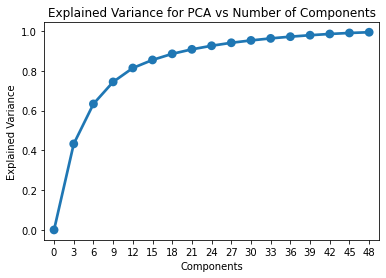

In [27]:
## Code to apply PCA with different number of components 
PCA_DICT  = {}
for i in range(0,50,3):
    pca = PCA(i)
    transformed = pca.fit_transform(numpy_data)
    PCA_DICT[i] = pca.explained_variance_ratio_.sum()

## Plot explained variance ration vs number of components in the PCA
plt.title('Explained Variance for PCA vs Number of Components')
plt.xlabel('Components')
plt.ylabel('Explained Variance')
sns.pointplot(x=list(PCA_DICT.keys()),y=list(PCA_DICT.values()))
plt.show()

In [28]:
## Choosing 30 as final PCA components 
pca = PCA(30)
transformed = pca.fit_transform(numpy_data)
print(pca.explained_variance_ratio_.sum())
data_transformed = pd.DataFrame(transformed)

0.953437575048477


C:\Users\raghu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


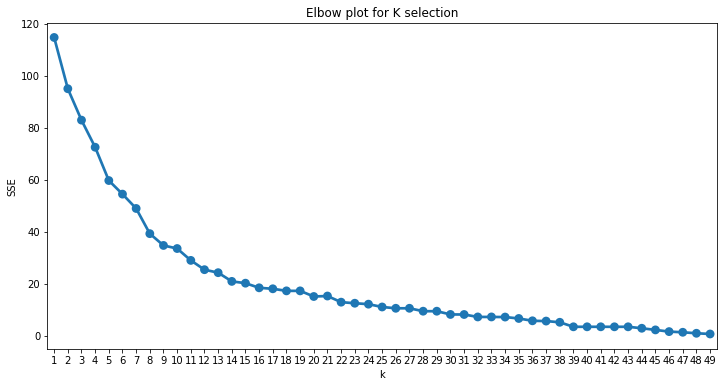

In [29]:
## Elbow plot with KMeans with clusters ranging from 1 to 50 
sse = {}
for k in range(1, 50):
    kmeans = KMeans(init="random",n_clusters=k,random_state=42,)
    kmeans.fit(data_transformed)
    sse[k] = kmeans.inertia_

fig = plt.figure(figsize=(12, 6))
plt.title('Elbow plot for K selection')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),
             y=list(sse.values()))
plt.show()

In [30]:
# from kneed import KneeLocator
## Code to find knee in the Elbow plot with knee locator 
kl = KneeLocator(range(1, 50), list(sse.values()), curve="convex", direction="decreasing")
print(kl.knee)

14


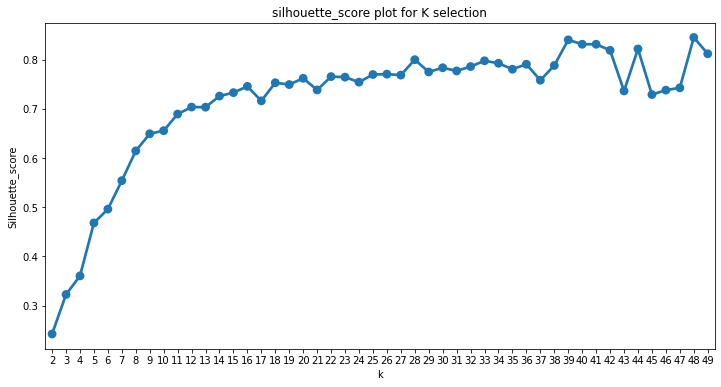

In [31]:
## Finding optimal clusters with silhouette score - plot score vs number of clusters 
from sklearn.metrics import silhouette_score
SHIT_Score = {}
for k in range(2, 50):
    kmeans = KMeans(init="random",n_clusters=k,random_state=42,)
    kmeans.fit(data_transformed)
    SHIT_Score[k] = silhouette_score(data_transformed,kmeans.labels_)

fig = plt.figure(figsize=(12, 6))
plt.title('silhouette_score plot for K selection')
plt.xlabel('k')
plt.ylabel('Silhouette_score')
sns.pointplot(x=list(SHIT_Score.keys()),
             y=list(SHIT_Score.values()))
plt.show()

In [32]:
import shapefile
## Keep in mind to first import fiona then geopandas 
import fiona
import geopandas

In [33]:
## Create cluster labels on the data 
kmeans = KMeans(init="random",n_clusters=16,random_state=42,)
kmeans.fit(data_transformed)
print(kmeans.inertia_)
country_df['CLUSTERS'] = kmeans.labels_

18.4973501700469


In [34]:
ALL_CLUSTERS_DF['CLUSTER_ORG'] = country_df['CLUSTERS']

In [35]:
## Import the map file 
world = geopandas.read_file("C://Users//raghu//Downloads//Compressed/TM_WORLD_BORDERS-0.3.zip")

<AxesSubplot:>

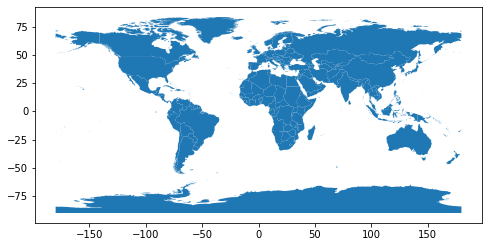

In [36]:
## Check if file is good - if you get this plot then everything is good 
world.plot(figsize=(8,6))

In [37]:
import matplotlib.patches as mpatches ## Patches to create Legend 

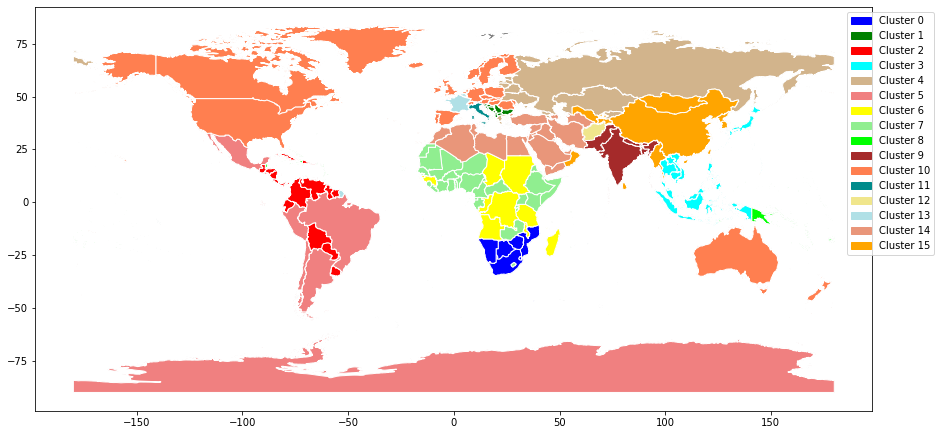

In [38]:
## plotting the cluster 
color_list = ['blue','green','red','cyan','tan','lightcoral','yellow','lightgreen','lime','brown',\
              'coral','darkcyan','khaki','powderblue','darksalmon','orange','lightcyan','plum']
clusters = np.unique(country_df['CLUSTERS'])
patches = [ eval('''mpatches.Patch(color='{colour}', label='Cluster {cluster_num}')'''\
                         .format(colour=color_list[cluster_num],cluster_num=cluster_num)) for cluster_num in clusters ]

ax2 = world.plot(figsize=(15,15), edgecolor=u'white', color='gray')
for cluster_num in clusters:
    world[world['NAME'].isin(list(country_df[country_df['CLUSTERS'] == cluster_num]['COUNTRY']))]\
                                                        .plot(edgecolor=u'white', color=color_list[cluster_num], ax=ax2)
    ax2.axis('scaled')

plt.legend(handles=patches,bbox_to_anchor=(1.08, 1))
plt.show()

In [39]:
from wordcloud import WordCloud

In [40]:
print(len(list(country_df[country_df['CLUSTERS'] == 10]['COUNTRY'])))
print(list(country_df[country_df['CLUSTERS'] == 10]['COUNTRY']))

33
['American Samoa', 'Andorra', 'Australia', 'Austria', 'Canada', 'Czech Republic', 'Denmark', 'Faroe Islands', 'Finland', 'Germany', 'Gibraltar', 'Greenland', 'Hungary', 'Iceland', 'Ireland', 'Isle of Man', 'Israel', 'Jersey', 'Liechtenstein', 'Republic of Moldova', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Romania', 'Samoa', 'Slovakia', 'Spain', 'Sweden', 'Switzerland', 'United States', 'United Kingdom']


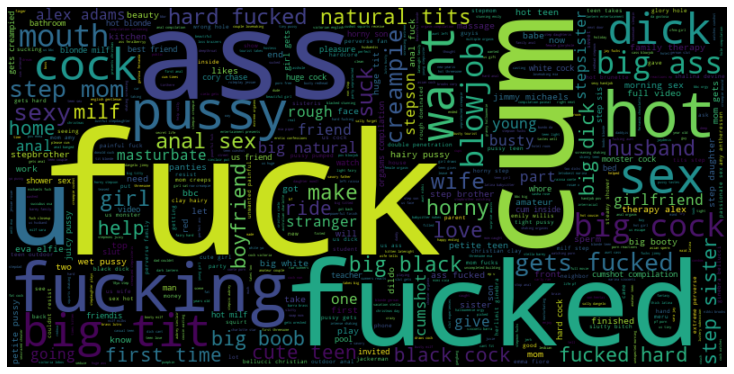

In [41]:
text = ' '.join(country_df[country_df['CLUSTERS'] == 10]['TITLE'])
wordcloud = WordCloud(width=800,height=400,max_words=1000,).generate(text)

# Display the generated image:
plt.figure( figsize=(10,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [42]:
print(len(list(country_df[country_df['CLUSTERS'] == 15]['COUNTRY'])))
print(list(country_df[country_df['CLUSTERS'] == 15]['COUNTRY']))

18
['Brunei Darussalam', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Guam', 'Hong Kong', 'Korea, Republic of', "Korea, Democratic People's Republic of", 'Macau', 'Maldives', 'Mongolia', 'Burma', 'Oman', 'Singapore', 'Sri Lanka', 'Taiwan', 'Tajikistan', 'Uzbekistan']


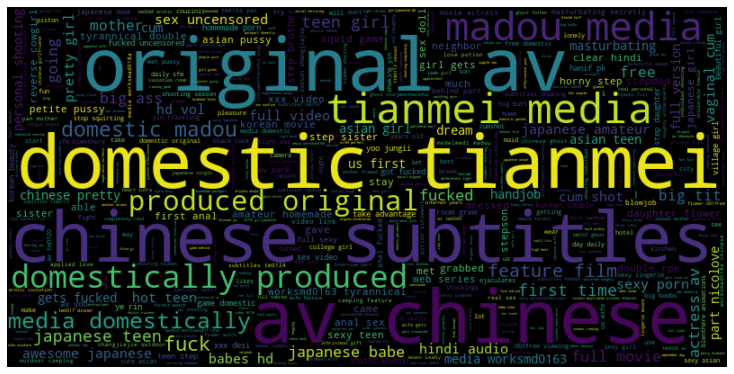

In [43]:
text = ' '.join(country_df[country_df['CLUSTERS'] == 15]['TITLE'])
wordcloud = WordCloud(width=800,height=400,max_words=1000,).generate(text)

# Display the generated image:
plt.figure( figsize=(10,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Experiment 1 - 'HOME' Section first Page

In [44]:
country_df = df.loc[ (df['CATEGORY'] == 'HOME') & (df['PAGE_NUMBER'] == 1),['TITLE','COUNTRY'] ].drop_duplicates()\
                                                                .groupby('COUNTRY').agg({'TITLE':' '.join}).reset_index()
country_df['TITLE'] = country_df['TITLE'].apply(lambda x: re.sub(' +', ' ',x)) # remove extar white spaces
## Not needed 
replace_dict = {'Virgin Islands, British':'British Virgin Islands','Virgin Islands, U.S.':'United States Virgin Islands',
               'Vietnam':'Viet Nam','USA':'United States','Wallis and Futuna':'Wallis and Futuna Islands',
               'Moldova, Republic of':'Republic of Moldova','Congo, The Democratic Republic of the':'Democratic Republic of the Congo',
               'Macao':'Macau','Korea':'Korea, Republic of','Tanzania, United Republic of':'United Republic of Tanzania',
               'Åland Islands':'Εland Islands','Holy See (Vatican City State)':'Holy See (Vatican City)',
               'Iran, Islamic Republic of':'Iran (Islamic Republic of)','Macedonia':'The former Yugoslav Republic of Macedonia',
               'Libya':'Libyan Arab Jamahiriya','Saint-Barthélemy':'Saint Barthelemy','Palestinian Territory':'Palestine','Myanmar':'Burma'}

country_df['COUNTRY'] = country_df['COUNTRY'].replace(replace_dict)
country_df['TOKENS'] = country_df['TITLE'].apply(lambda x: tokenize.word_tokenize(x)) ## Create tokens from the titles/text

country_df['TOKENS'].map(lambda x: len(x)).mean() ## Average number of tokens for combined titles for each country 

## TFIDF on tokens with ngrams and min_df 
tfidf = TfidfVectorizer(tokenizer=lambda x: x,preprocessor=lambda x: x,ngram_range=(1,3),min_df=5)
vectorised_data = tfidf.fit_transform(country_df['TOKENS'].values)
numpy_data = vectorised_data.toarray() ## sparse matrix of tdidf values to numpy array 
data = pd.DataFrame(numpy_data,columns=tfidf.vocabulary_.keys()) ## dataframe from numpy 

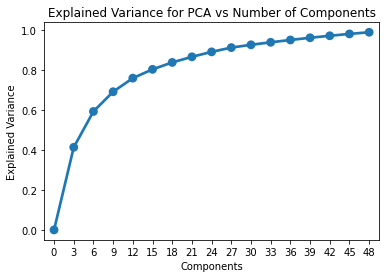

In [45]:
## Code to apply PCA with different number of components 
PCA_DICT  = {}
for i in range(0,50,3):
    pca = PCA(i)
    transformed = pca.fit_transform(numpy_data)
    PCA_DICT[i] = pca.explained_variance_ratio_.sum()

## Plot explained variance ration vs number of components in the PCA
plt.title('Explained Variance for PCA vs Number of Components')
plt.xlabel('Components')
plt.ylabel('Explained Variance')
sns.pointplot(x=list(PCA_DICT.keys()),y=list(PCA_DICT.values()))
plt.show()

In [46]:
## Choosing 30 as final PCA components 
pca = PCA(36)
transformed = pca.fit_transform(numpy_data)
print(pca.explained_variance_ratio_.sum())
data_transformed = pd.DataFrame(transformed)

0.9494651503484643


C:\Users\raghu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


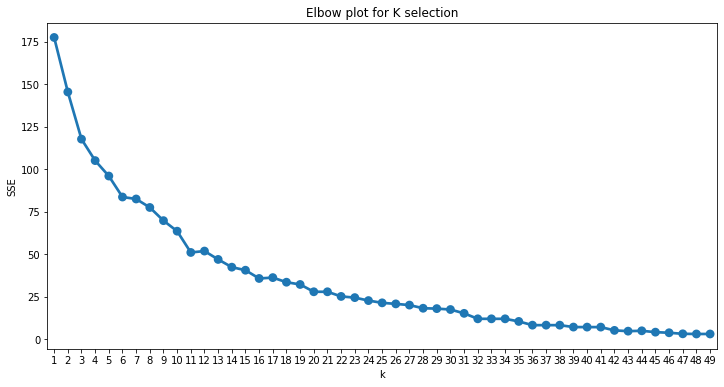

In [47]:
## Elbow plot with KMeans with clusters ranging from 1 to 50 
sse = {}
for k in range(1, 50):
    kmeans = KMeans(init="random",n_clusters=k,random_state=42,)
    kmeans.fit(data_transformed)
    sse[k] = kmeans.inertia_

fig = plt.figure(figsize=(12, 6))
plt.title('Elbow plot for K selection')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),
             y=list(sse.values()))
plt.show()

In [48]:
# from kneed import KneeLocator
## Code to find knee in the Elbow plot with knee locator 
kl = KneeLocator(range(1, 50), list(sse.values()), curve="convex", direction="decreasing")
print(kl.knee)

11


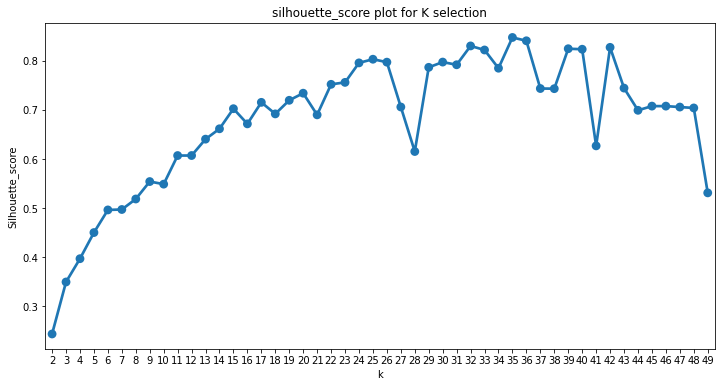

In [49]:
## Finding optimal clusters with silhouette score - plot score vs number of clusters 
from sklearn.metrics import silhouette_score
SHIT_Score = {}
for k in range(2, 50):
    kmeans = KMeans(init="random",n_clusters=k,random_state=42,)
    kmeans.fit(data_transformed)
    SHIT_Score[k] = silhouette_score(data_transformed,kmeans.labels_)

fig = plt.figure(figsize=(12, 6))
plt.title('silhouette_score plot for K selection')
plt.xlabel('k')
plt.ylabel('Silhouette_score')
sns.pointplot(x=list(SHIT_Score.keys()),
             y=list(SHIT_Score.values()))
plt.show()

In [50]:
## Create cluster labels on the data 
kmeans = KMeans(init="random",n_clusters=16,random_state=42,)
kmeans.fit(data_transformed)
print(kmeans.inertia_)
country_df['CLUSTERS'] = kmeans.labels_

35.79305642853066


In [51]:
ALL_CLUSTERS_DF['CLUSTER_EXP1'] = country_df['CLUSTERS']

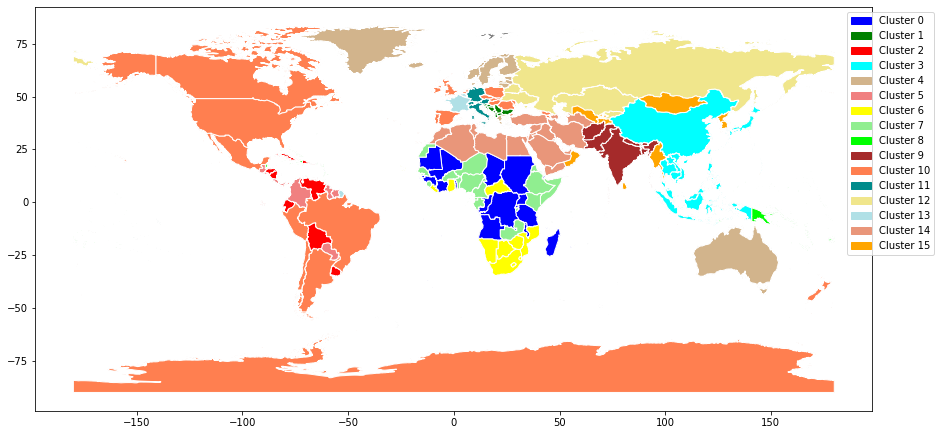

In [52]:
## plotting the cluster 
color_list = ['blue','green','red','cyan','tan','lightcoral','yellow','lightgreen','lime','brown',\
              'coral','darkcyan','khaki','powderblue','darksalmon','orange','lightcyan','plum']
clusters = np.unique(country_df['CLUSTERS'])
patches = [ eval('''mpatches.Patch(color='{colour}', label='Cluster {cluster_num}')'''\
                         .format(colour=color_list[cluster_num],cluster_num=cluster_num)) for cluster_num in clusters ]

ax2 = world.plot(figsize=(15,15), edgecolor=u'white', color='gray')
for cluster_num in clusters:
    world[world['NAME'].isin(list(country_df[country_df['CLUSTERS'] == cluster_num]['COUNTRY']))]\
                                                        .plot(edgecolor=u'white', color=color_list[cluster_num], ax=ax2)
    ax2.axis('scaled')

plt.legend(handles=patches,bbox_to_anchor=(1.08, 1))
# plt.savefig('C:/Users/raghu/Desktop/Home_Page_1.jpg')
plt.show()

15
['American Samoa', 'Australia', 'Cyprus', 'Denmark', 'Estonia', 'Faroe Islands', 'Finland', 'Greece', 'Greenland', 'Iceland', 'Latvia', 'Lithuania', 'Norway', 'Samoa', 'Sweden']


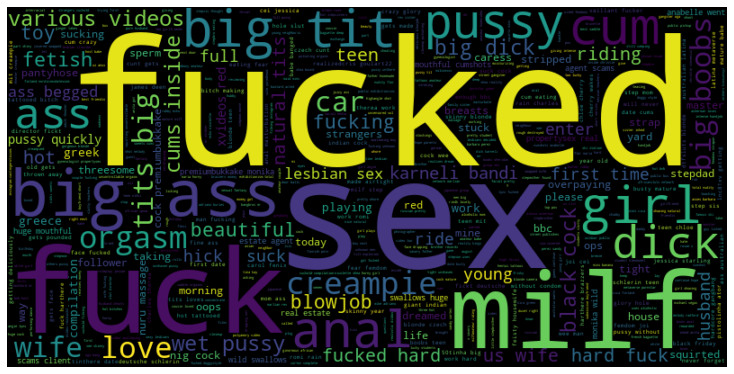

In [54]:
print(len(list(country_df[country_df['CLUSTERS'] == 4]['COUNTRY'])))
print(list(country_df[country_df['CLUSTERS'] == 4]['COUNTRY']))

text = ' '.join(country_df[country_df['CLUSTERS'] == 4]['TITLE'])
wordcloud = WordCloud(width=800,height=400,max_words=1000,).generate(text)

# Display the generated image:
plt.figure( figsize=(10,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

27
['Andorra', 'Antarctica', 'Argentina', 'Armenia', 'Brazil', 'Canada', 'Chile', 'Czech Republic', 'Georgia', 'Gibraltar', 'Hungary', 'Ireland', 'Isle of Man', 'Israel', 'Jersey', 'Mexico', 'Republic of Moldova', 'Netherlands', 'New Zealand', 'Peru', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Spain', 'United States', 'United Kingdom']


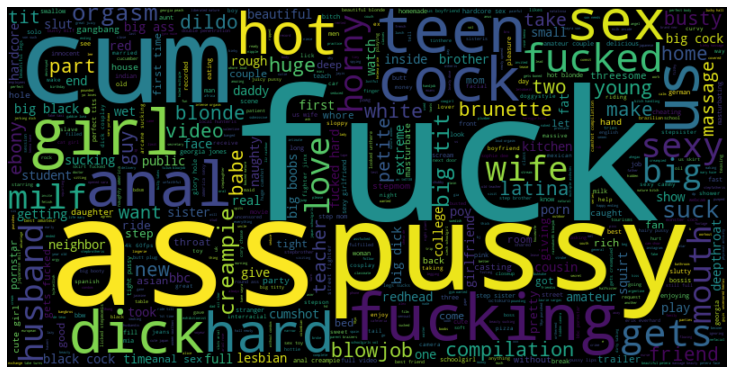

In [55]:
print(len(list(country_df[country_df['CLUSTERS'] == 10]['COUNTRY'])))
print(list(country_df[country_df['CLUSTERS'] == 10]['COUNTRY']))

text = ' '.join(country_df[country_df['CLUSTERS'] == 10]['TITLE'])
wordcloud = WordCloud(width=800,height=400,max_words=1000,).generate(text)

# Display the generated image:
plt.figure( figsize=(10,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

###  Experiment 2 - All data from 'HOME' Section/Category

In [56]:
country_df = df.loc[ (df['CATEGORY'] == 'HOME'),['TITLE','COUNTRY'] ].drop_duplicates()\
                                                                .groupby('COUNTRY').agg({'TITLE':' '.join}).reset_index()
country_df['TITLE'] = country_df['TITLE'].apply(lambda x: re.sub(' +', ' ',x)) # remove extar white spaces
## Not needed 
replace_dict = {'Virgin Islands, British':'British Virgin Islands','Virgin Islands, U.S.':'United States Virgin Islands',
               'Vietnam':'Viet Nam','USA':'United States','Wallis and Futuna':'Wallis and Futuna Islands',
               'Moldova, Republic of':'Republic of Moldova','Congo, The Democratic Republic of the':'Democratic Republic of the Congo',
               'Macao':'Macau','Korea':'Korea, Republic of','Tanzania, United Republic of':'United Republic of Tanzania',
               'Åland Islands':'Εland Islands','Holy See (Vatican City State)':'Holy See (Vatican City)',
               'Iran, Islamic Republic of':'Iran (Islamic Republic of)','Macedonia':'The former Yugoslav Republic of Macedonia',
               'Libya':'Libyan Arab Jamahiriya','Saint-Barthélemy':'Saint Barthelemy','Palestinian Territory':'Palestine','Myanmar':'Burma'}

country_df['COUNTRY'] = country_df['COUNTRY'].replace(replace_dict)
country_df['TOKENS'] = country_df['TITLE'].apply(lambda x: tokenize.word_tokenize(x)) ## Create tokens from the titles/text

country_df['TOKENS'].map(lambda x: len(x)).mean() ## Average number of tokens for combined titles for each country 

## TFIDF on tokens with ngrams and min_df 
tfidf = TfidfVectorizer(tokenizer=lambda x: x,preprocessor=lambda x: x,ngram_range=(1,3),min_df=5)
vectorised_data = tfidf.fit_transform(country_df['TOKENS'].values)
numpy_data = vectorised_data.toarray() ## sparse matrix of tdidf values to numpy array 
data = pd.DataFrame(numpy_data,columns=tfidf.vocabulary_.keys()) ## dataframe from numpy 

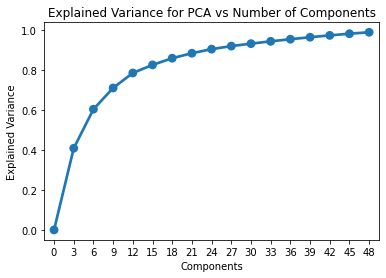

In [57]:
## Code to apply PCA with different number of components 
PCA_DICT  = {}
for i in range(0,50,3):
    pca = PCA(i)
    transformed = pca.fit_transform(numpy_data)
    PCA_DICT[i] = pca.explained_variance_ratio_.sum()

## Plot explained variance ration vs number of components in the PCA
plt.title('Explained Variance for PCA vs Number of Components')
plt.xlabel('Components')
plt.ylabel('Explained Variance')
sns.pointplot(x=list(PCA_DICT.keys()),y=list(PCA_DICT.values()))
plt.show()

In [58]:
## Choosing 30 as final PCA components 
pca = PCA(36)
transformed = pca.fit_transform(numpy_data)
print(pca.explained_variance_ratio_.sum())
data_transformed = pd.DataFrame(transformed)

0.9540881342152671


C:\Users\raghu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


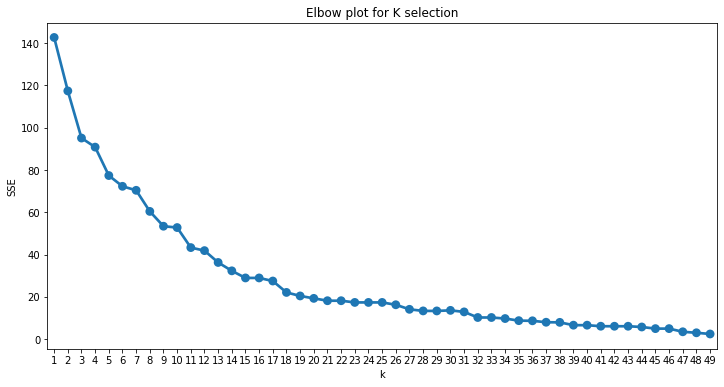

In [59]:
## Elbow plot with KMeans with clusters ranging from 1 to 50 
sse = {}
for k in range(1, 50):
    kmeans = KMeans(init="random",n_clusters=k,random_state=42,)
    kmeans.fit(data_transformed)
    sse[k] = kmeans.inertia_

fig = plt.figure(figsize=(12, 6))
plt.title('Elbow plot for K selection')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),
             y=list(sse.values()))
plt.show()

In [60]:
# from kneed import KneeLocator
## Code to find knee in the Elbow plot with knee locator 
kl = KneeLocator(range(1, 50), list(sse.values()), curve="convex", direction="decreasing")
print(kl.knee)

15


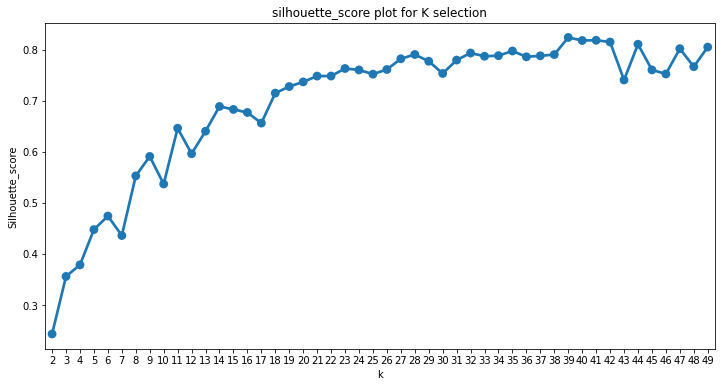

In [61]:
## Finding optimal clusters with silhouette score - plot score vs number of clusters 
from sklearn.metrics import silhouette_score
SHIT_Score = {}
for k in range(2, 50):
    kmeans = KMeans(init="random",n_clusters=k,random_state=42,)
    kmeans.fit(data_transformed)
    SHIT_Score[k] = silhouette_score(data_transformed,kmeans.labels_)

fig = plt.figure(figsize=(12, 6))
plt.title('silhouette_score plot for K selection')
plt.xlabel('k')
plt.ylabel('Silhouette_score')
sns.pointplot(x=list(SHIT_Score.keys()),
             y=list(SHIT_Score.values()))
plt.show()

In [62]:
## Create cluster labels on the data 
kmeans = KMeans(init="random",n_clusters=16,random_state=42,)
kmeans.fit(data_transformed)
print(kmeans.inertia_)
country_df['CLUSTERS'] = kmeans.labels_

28.974298875984424


In [63]:
ALL_CLUSTERS_DF['CLUSTER_EXP2'] = country_df['CLUSTERS']

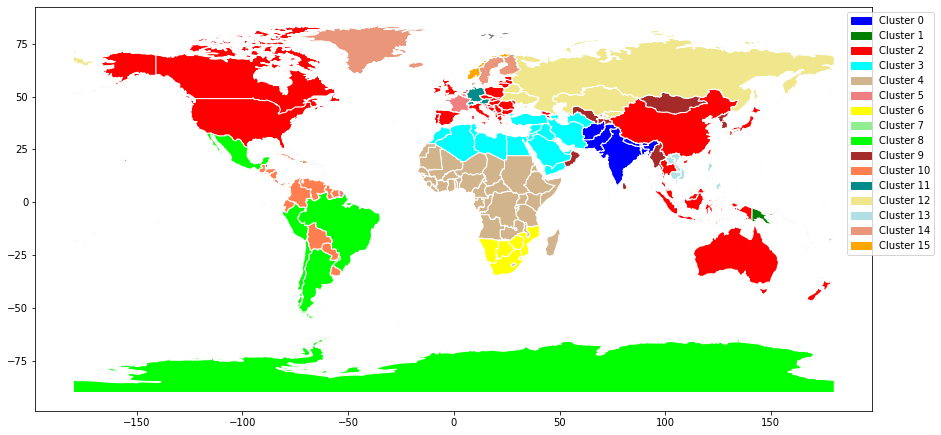

In [64]:
## plotting the cluster 
color_list = ['blue','green','red','cyan','tan','lightcoral','yellow','lightgreen','lime','brown',\
              'coral','darkcyan','khaki','powderblue','darksalmon','orange','lightcyan','plum']
clusters = np.unique(country_df['CLUSTERS'])
patches = [ eval('''mpatches.Patch(color='{colour}', label='Cluster {cluster_num}')'''\
                         .format(colour=color_list[cluster_num],cluster_num=cluster_num)) for cluster_num in clusters ]

ax2 = world.plot(figsize=(15,15), edgecolor=u'white', color='gray')
for cluster_num in clusters:
    world[world['NAME'].isin(list(country_df[country_df['CLUSTERS'] == cluster_num]['COUNTRY']))]\
                                                        .plot(edgecolor=u'white', color=color_list[cluster_num], ax=ax2)
    ax2.axis('scaled')

plt.legend(handles=patches,bbox_to_anchor=(1.08, 1))
# plt.savefig('C:/Users/raghu/Desktop/Home_Page_1.jpg')
plt.show()

48
['Albania', 'American Samoa', 'Andorra', 'Armenia', 'Australia', 'Bosnia and Herzegovina', 'Bulgaria', 'Canada', 'China', 'Croatia', 'Cyprus', 'Czech Republic', 'Estonia', 'Georgia', 'Gibraltar', 'Greece', 'Holy See (Vatican City)', 'Hungary', 'Indonesia', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Japan', 'Jersey', 'Kosovo', 'Latvia', 'Lithuania', 'The former Yugoslav Republic of Macedonia', 'Malaysia', 'Malta', 'Republic of Moldova', 'Montenegro', 'Netherlands', 'New Zealand', 'Poland', 'Portugal', 'Romania', 'Samoa', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Taiwan', 'Thailand', 'United States', 'United Kingdom']


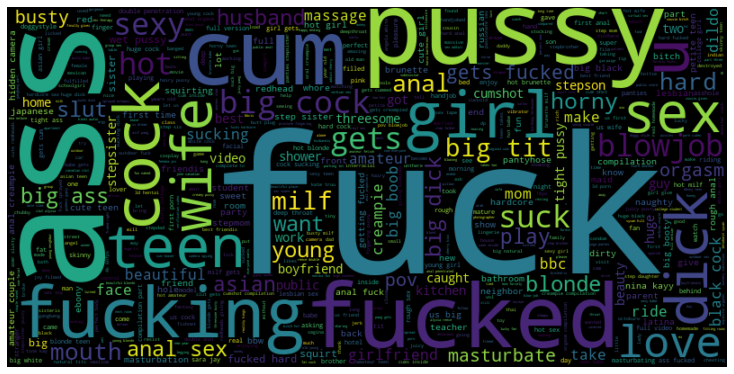

In [66]:
print(len(list(country_df[country_df['CLUSTERS'] == 2]['COUNTRY'])))
print(list(country_df[country_df['CLUSTERS'] == 2]['COUNTRY']))

text = ' '.join(country_df[country_df['CLUSTERS'] == 2]['TITLE'])
wordcloud = WordCloud(width=800,height=400,max_words=1000,).generate(text)

# Display the generated image:
plt.figure( figsize=(10,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

16
['Brunei Darussalam', 'Christmas Island', 'Cocos (Keeling) Islands', 'Guam', 'Hong Kong', 'Korea, Republic of', "Korea, Democratic People's Republic of", 'Macau', 'Maldives', 'Mongolia', 'Burma', 'Oman', 'Singapore', 'Sri Lanka', 'Tajikistan', 'Uzbekistan']


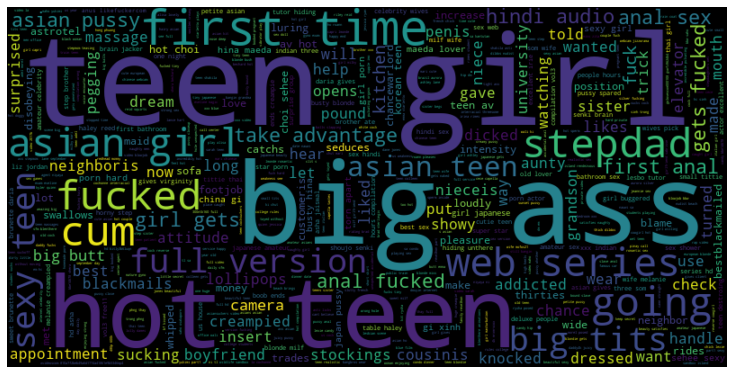

In [69]:
print(len(list(country_df[country_df['CLUSTERS'] == 9]['COUNTRY'])))
print(list(country_df[country_df['CLUSTERS'] == 9]['COUNTRY']))

text = ' '.join(country_df[country_df['CLUSTERS'] == 9]['TITLE'])
wordcloud = WordCloud(width=800,height=400,max_words=1000,).generate(text)

# Display the generated image:
plt.figure( figsize=(10,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

###  Experiment 3 - All data from 'BEST' Section/Category

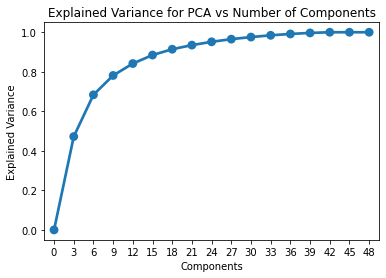

In [70]:
country_df = df.loc[ (df['CATEGORY'] == 'BEST'),['TITLE','COUNTRY'] ].drop_duplicates()\
                                                                .groupby('COUNTRY').agg({'TITLE':' '.join}).reset_index()
country_df['TITLE'] = country_df['TITLE'].apply(lambda x: re.sub(' +', ' ',x)) # remove extar white spaces
replace_dict = {'Virgin Islands, British':'British Virgin Islands','Virgin Islands, U.S.':'United States Virgin Islands',
               'Vietnam':'Viet Nam','USA':'United States','Wallis and Futuna':'Wallis and Futuna Islands',
               'Moldova, Republic of':'Republic of Moldova','Congo, The Democratic Republic of the':'Democratic Republic of the Congo',
               'Macao':'Macau','Korea':'Korea, Republic of','Tanzania, United Republic of':'United Republic of Tanzania',
               'Åland Islands':'Εland Islands','Holy See (Vatican City State)':'Holy See (Vatican City)',
               'Iran, Islamic Republic of':'Iran (Islamic Republic of)','Macedonia':'The former Yugoslav Republic of Macedonia',
               'Libya':'Libyan Arab Jamahiriya','Saint-Barthélemy':'Saint Barthelemy','Palestinian Territory':'Palestine','Myanmar':'Burma'}

country_df['COUNTRY'] = country_df['COUNTRY'].replace(replace_dict)
country_df['TOKENS'] = country_df['TITLE'].apply(lambda x: tokenize.word_tokenize(x)) ## Create tokens from the titles/text

country_df['TOKENS'].map(lambda x: len(x)).mean() ## Average number of tokens for combined titles for each country 

## TFIDF on tokens with ngrams and min_df 
tfidf = TfidfVectorizer(tokenizer=lambda x: x,preprocessor=lambda x: x,ngram_range=(1,3),min_df=5)
vectorised_data = tfidf.fit_transform(country_df['TOKENS'].values)
numpy_data = vectorised_data.toarray() ## sparse matrix of tdidf values to numpy array 
data = pd.DataFrame(numpy_data,columns=tfidf.vocabulary_.keys()) ## dataframe from numpy 

## Code to apply PCA with different number of components 
PCA_DICT  = {}
for i in range(0,50,3):
    pca = PCA(i)
    transformed = pca.fit_transform(numpy_data)
    PCA_DICT[i] = pca.explained_variance_ratio_.sum()

## Plot explained variance ration vs number of components in the PCA
plt.title('Explained Variance for PCA vs Number of Components')
plt.xlabel('Components')
plt.ylabel('Explained Variance')
sns.pointplot(x=list(PCA_DICT.keys()),y=list(PCA_DICT.values()))
plt.show()

In [71]:
## Choosing 30 as final PCA components 
pca = PCA(25)
transformed = pca.fit_transform(numpy_data)
print(pca.explained_variance_ratio_.sum())
data_transformed = pd.DataFrame(transformed)

0.956421295613629


C:\Users\raghu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


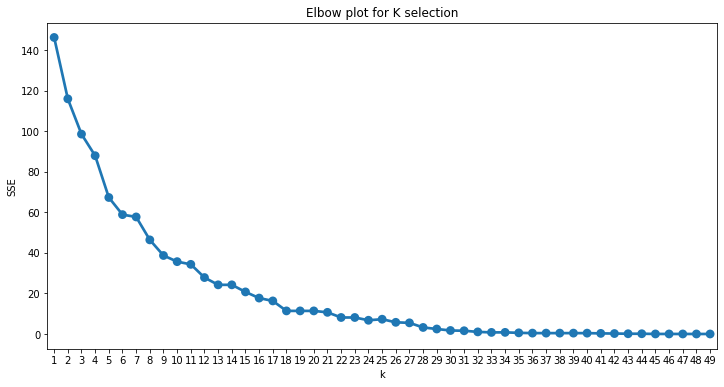

In [72]:
## Elbow plot with KMeans with clusters ranging from 1 to 50 
sse = {}
for k in range(1, 50):
    kmeans = KMeans(init="random",n_clusters=k,random_state=42,)
    kmeans.fit(data_transformed)
    sse[k] = kmeans.inertia_

fig = plt.figure(figsize=(12, 6))
plt.title('Elbow plot for K selection')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),
             y=list(sse.values()))
plt.show()

In [73]:
# from kneed import KneeLocator
## Code to find knee in the Elbow plot with knee locator 
kl = KneeLocator(range(1, 50), list(sse.values()), curve="convex", direction="decreasing")
print(kl.knee)

18


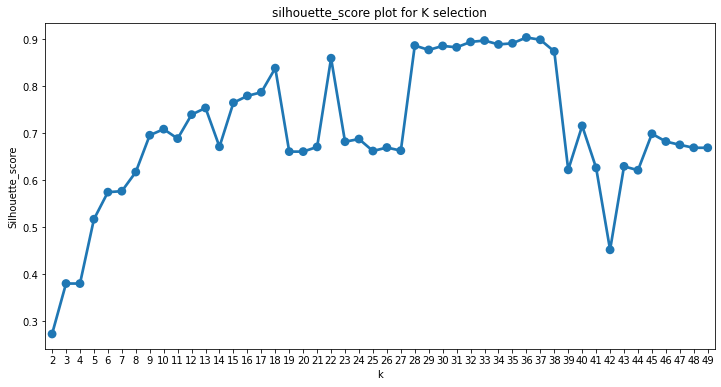

In [74]:
## Finding optimal clusters with silhouette score - plot score vs number of clusters 
from sklearn.metrics import silhouette_score
SHIT_Score = {}
for k in range(2, 50):
    kmeans = KMeans(init="random",n_clusters=k,random_state=42,)
    kmeans.fit(data_transformed)
    SHIT_Score[k] = silhouette_score(data_transformed,kmeans.labels_)

fig = plt.figure(figsize=(12, 6))
plt.title('silhouette_score plot for K selection')
plt.xlabel('k')
plt.ylabel('Silhouette_score')
sns.pointplot(x=list(SHIT_Score.keys()),
             y=list(SHIT_Score.values()))
plt.show()

In [75]:
## Create cluster labels on the data 
kmeans = KMeans(init="random",n_clusters=18,random_state=42,)
kmeans.fit(data_transformed)
print(kmeans.inertia_)
country_df['CLUSTERS'] = kmeans.labels_

11.389273426873212


In [76]:
ALL_CLUSTERS_DF['CLUSTER_EXP3'] = country_df['CLUSTERS']

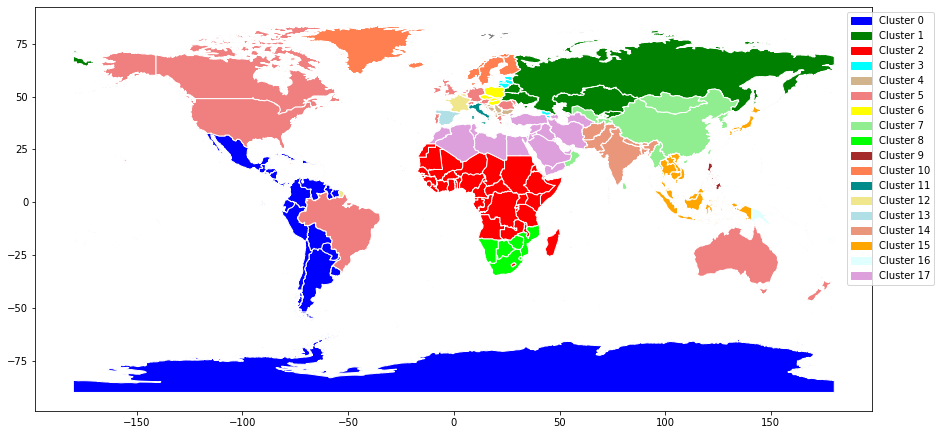

In [77]:
## plotting the cluster 
color_list = ['blue','green','red','cyan','tan','lightcoral','yellow','lightgreen','lime','brown',\
              'coral','darkcyan','khaki','powderblue','darksalmon','orange','lightcyan','plum']
clusters = np.unique(country_df['CLUSTERS'])
patches = [ eval('''mpatches.Patch(color='{colour}', label='Cluster {cluster_num}')'''\
                         .format(colour=color_list[cluster_num],cluster_num=cluster_num)) for cluster_num in clusters ]

ax2 = world.plot(figsize=(15,15), edgecolor=u'white', color='gray')
for cluster_num in clusters:
    world[world['NAME'].isin(list(country_df[country_df['CLUSTERS'] == cluster_num]['COUNTRY']))]\
                                                        .plot(edgecolor=u'white', color=color_list[cluster_num], ax=ax2)
    ax2.axis('scaled')

plt.legend(handles=patches,bbox_to_anchor=(1.08, 1))
# plt.savefig('C:/Users/raghu/Desktop/Home_Page_1.jpg')
plt.show()

22
['American Samoa', 'Australia', 'Austria', 'Brazil', 'Canada', 'Cyprus', 'Germany', 'Greece', 'Ireland', 'Isle of Man', 'Israel', 'Jersey', 'Liechtenstein', 'Republic of Moldova', 'Netherlands', 'New Zealand', 'Portugal', 'Romania', 'Samoa', 'Switzerland', 'United States', 'United Kingdom']


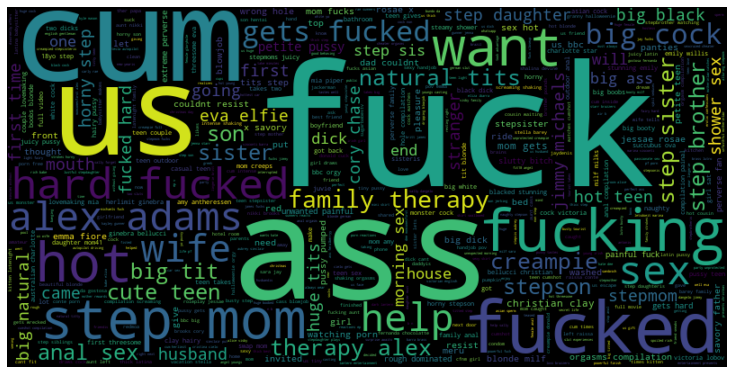

In [79]:
print(len(list(country_df[country_df['CLUSTERS'] == 5]['COUNTRY'])))
print(list(country_df[country_df['CLUSTERS'] == 5]['COUNTRY']))

text = ' '.join(country_df[country_df['CLUSTERS'] == 5]['TITLE'])
wordcloud = WordCloud(width=800,height=400,max_words=1000,).generate(text)

# Display the generated image:
plt.figure( figsize=(10,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

7
['Cambodia', 'Indonesia', 'Japan', "Lao People's Democratic Republic", 'Malaysia', 'Thailand', 'Viet Nam']


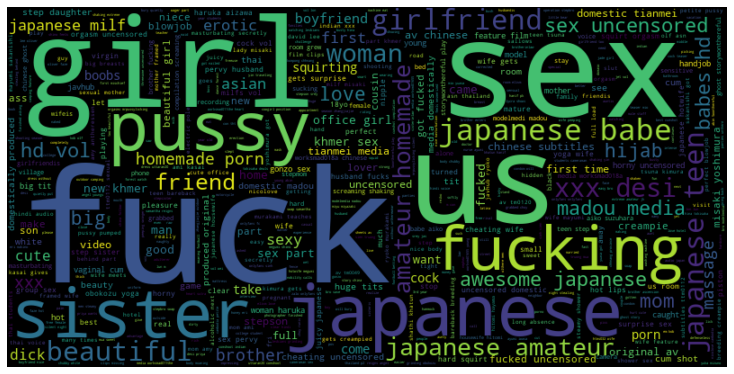

In [83]:
print(len(list(country_df[country_df['CLUSTERS'] == 15]['COUNTRY'])))
print(list(country_df[country_df['CLUSTERS'] == 15]['COUNTRY']))

text = ' '.join(country_df[country_df['CLUSTERS'] == 15]['TITLE'])
wordcloud = WordCloud(width=800,height=400,max_words=1000,).generate(text)

# Display the generated image:
plt.figure( figsize=(10,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [76]:
# ALL_CLUSTERS_DF.to_csv('C:/Users/raghu/Desktop/FINAL_CLUSTERS.csv',index=False)

In [41]:
clusters = pd.read_csv('C:/Users/raghu/Desktop/FINAL_CLUSTERS.csv')

In [51]:
df = pd.read_csv('C:/Users/raghu/Desktop/PORNOGRAPHY_DATA.csv')  ## Reading the pornography csv file 
## Regex to remove links from the links from the text
link_regex = re.compile(r'(?:ftp|https?|www|file)\.?:?[//|\\\\]?[\w\d:#@%/;$()~_?\+-=\\\&]+\.[\w\d:#@%/;$~_?\+-=\\\&]+')
df['TITLE'] = df['TITLE'].apply(lambda x: re.sub(link_regex,'',x))

df['TITLE'] = df['TITLE'].str.lower() ## lowercase all the text

## Read the contraction file
file = open('D:/MSC/NLP/NLP_ASS2/semeval-tweets/NEEDED/' + 'CONTRACTIONS.pkl', "rb")
CONTRACTION_MAP = pickle.load(file)
sleep(1)
del file
contraction = sorted(CONTRACTION_MAP, key=len, reverse=True)
c_re = re.compile('(%s)' % '|'.join(contraction))

## Function to expand the contrations
def expandContractions(text, c_re=c_re):
    def replace(match):
        return CONTRACTION_MAP[match.group(0)]
    return c_re.sub(replace, text.lower())
df['TITLE'] = df['TITLE'].apply(lambda x: expandContractions(x)) ## Applying function to expand ocntractions to text


df['TITLE'] = df['TITLE'].apply(lambda x: re.sub(r"['!\"“”‘’.?!…,:;]",'',x)) ## Remove punctutations


df['TITLE'] = df['TITLE'].apply(lambda x: re.sub(r'[^a-zA-Z\s0-9]','',x)) ## Keep only alphanumeric english characters

########################################################################################################################
## original 
country_df = df[['TITLE','COUNTRY']].drop_duplicates().groupby('COUNTRY').agg({'TITLE':' '.join}).reset_index()
## EXP1
# country_df = df.loc[ (df['CATEGORY'] == 'HOME') & (df['PAGE_NUMBER'] == 1),['TITLE','COUNTRY'] ].drop_duplicates()\
#                                                                 .groupby('COUNTRY').agg({'TITLE':' '.join}).reset_index()
# ## EXP2
# country_df = df.loc[ (df['CATEGORY'] == 'HOME'),['TITLE','COUNTRY'] ].drop_duplicates()\
#                                                                 .groupby('COUNTRY').agg({'TITLE':' '.join}).reset_index()
# ## EXP3
# country_df = df.loc[ (df['CATEGORY'] == 'BEST'),['TITLE','COUNTRY'] ].drop_duplicates()\
#                                                                 .groupby('COUNTRY').agg({'TITLE':' '.join}).reset_index()
##########################################################################################################################

country_df['TITLE'] = country_df['TITLE'].apply(lambda x: re.sub(' +', ' ',x)) # remove extar white spaces
## Not needed 
replace_dict = {'Virgin Islands, British':'British Virgin Islands','Virgin Islands, U.S.':'United States Virgin Islands',
               'Vietnam':'Viet Nam','USA':'United States','Wallis and Futuna':'Wallis and Futuna Islands',
               'Moldova, Republic of':'Republic of Moldova','Congo, The Democratic Republic of the':'Democratic Republic of the Congo',
               'Macao':'Macau','Korea':'Korea, Republic of','Tanzania, United Republic of':'United Republic of Tanzania',
               'Åland Islands':'Εland Islands','Holy See (Vatican City State)':'Holy See (Vatican City)',
               'Iran, Islamic Republic of':'Iran (Islamic Republic of)','Macedonia':'The former Yugoslav Republic of Macedonia',
               'Libya':'Libyan Arab Jamahiriya','Saint-Barthélemy':'Saint Barthelemy','Palestinian Territory':'Palestine','Myanmar':'Burma'}

country_df['COUNTRY'] = country_df['COUNTRY'].replace(replace_dict)

In [52]:
len(country_df.drop_duplicates('TITLE'))

78

In [ ]:
## Exp3 - 43
## Exp2 - 78
## Exp1 - 71
## Org - 78

In [19]:
# country_df['CLUSTERS'] = clusters['CLUSTER_ORG']
# country_df['CLUSTERS'] = clusters['CLUSTER_EXP1']
# country_df['CLUSTERS'] = clusters['CLUSTER_EXP2']
country_df['CLUSTERS'] = clusters['CLUSTER_EXP3']

In [20]:
uni_title_list = []
for clus_num in country_df['CLUSTERS'].unique():
    uni_title_list.append(len(country_df[country_df['CLUSTERS'] == clus_num].drop_duplicates('TITLE')))

In [21]:
sum(uni_title_list)
## 78 original (0.73)
## 71 Home page 1 (0.72)
## 78 Home All page - still variety (0.7)
## 44 Best all page (0.8)

44